# Построение прототипа книжного рекомендательного сервиса

In [1]:
# Установка библиотеки
!pip install implicit -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.3/70.3 kB 6.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
# Импорт
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import csr_matrix, coo_matrix
from scipy.sparse.linalg import svds
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import normalize
import implicit
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

print(f"implicit: {implicit.__version__}")

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error

from scipy import sparse
from math import log2

implicit: 0.7.2


In [3]:
# Загрузка данных
!git clone https://github.com/zygmuntz/goodbooks-10k.git 2>/dev/null || echo "📁 Данные загружены"

ratings = pd.read_csv('goodbooks-10k/ratings.csv')
books = pd.read_csv('goodbooks-10k/books.csv')
book_tags = pd.read_csv('goodbooks-10k/book_tags.csv')
tags = pd.read_csv('goodbooks-10k/tags.csv')

print(f"Ratings: {ratings.shape}")
print(f"Books: {books.shape}")
print(f"Book Tags: {book_tags.shape}")
print(f"Tags: {tags.shape}")

Ratings: (5976479, 3)
Books: (10000, 23)
Book Tags: (999912, 3)
Tags: (34252, 2)


# Связь датасетов


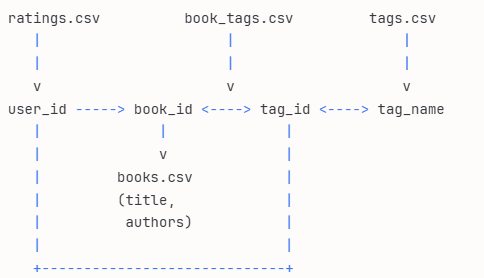

# Знакомство с данными и EDA

In [4]:
print("RATINGS")
display(ratings.head())
print("\n")
ratings.info()
print("\n")
print(ratings.describe())

RATINGS


,user_id,book_id,rating
0,1,258,5
1,2,4081,4
2,2,260,5
3,2,9296,5
4,2,2318,3




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5976479 entries, 0 to 5976478
Data columns (total 3 columns):
 #   Column   Dtype
---  ------   -----
 0   user_id  int64
 1   book_id  int64
 2   rating   int64
dtypes: int64(3)
memory usage: 136.8 MB


            user_id       book_id        rating
count  5.976479e+06  5.976479e+06  5.976479e+06
mean   2.622446e+04  2.006477e+03  3.919866e+00
std    1.541323e+04  2.468499e+03  9.910868e-01
min    1.000000e+00  1.000000e+00  1.000000e+00
25%    1.281300e+04  1.980000e+02  3.000000e+00
50%    2.593800e+04  8.850000e+02  4.000000e+00
75%    3.950900e+04  2.973000e+03  5.000000e+00
max    5.342400e+04  1.000000e+04  5.000000e+00


In [5]:
# проверим, есть ли пользователи, поставившие одной книге более одной оценки
duplicates = ratings.groupby(['user_id', 'book_id']).size().reset_index(name='count')
duplicates = duplicates[duplicates['count'] > 1]

if not duplicates.empty:
    print(f" Найдено {len(duplicates)} пар (user_id, book_id) с несколькими оценками.")
    display(duplicates.head(10))
else:
    print(" Все пары (user_id, book_id) уникальны — дубликатов нет.")

 Все пары (user_id, book_id) уникальны — дубликатов нет.


### Распределение оценок

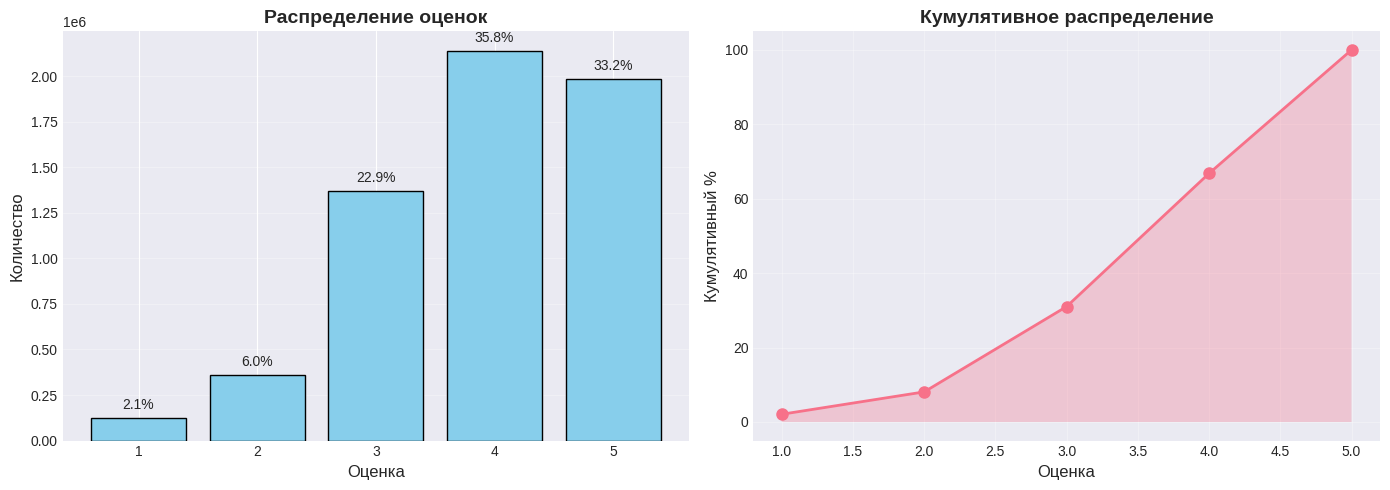


 Средняя оценка: 3.92
Медиана: 4
 Std: 0.99

 Смещение к высоким оценкам. 69.0% >= 4


In [6]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

rating_counts = ratings['rating'].value_counts().sort_index()

axes[0].bar(rating_counts.index, rating_counts.values, color='skyblue', edgecolor='black')
axes[0].set_xlabel('Оценка', fontsize=12)
axes[0].set_ylabel('Количество', fontsize=12)
axes[0].set_title('Распределение оценок', fontsize=14, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

total = len(ratings)
for i, v in enumerate(rating_counts.values):
    axes[0].text(rating_counts.index[i], v + 50000, f'{v/total*100:.1f}%', ha='center')

cumulative = rating_counts.cumsum() / rating_counts.sum() * 100
axes[1].plot(cumulative.index, cumulative.values, marker='o', linewidth=2, markersize=8)
axes[1].fill_between(cumulative.index, cumulative.values, alpha=0.3)
axes[1].set_xlabel('Оценка', fontsize=12)
axes[1].set_ylabel('Кумулятивный %', fontsize=12)
axes[1].set_title('Кумулятивное распределение', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n Средняя оценка: {ratings['rating'].mean():.2f}")
print(f"Медиана: {ratings['rating'].median():.0f}")
print(f" Std: {ratings['rating'].std():.2f}")
print(f"\n Смещение к высоким оценкам. {(ratings['rating'] >= 4).sum() / len(ratings) * 100:.1f}% >= 4")

Пользователи склонны ставить высокие оценки и в целом лояльны.
Только 31% оценок 3 и ниже, 69% - 4 и выше. Это свидетельствует
о том, что пользователи склонны оценивать только понравившиеся книги.

Это может повлиять на модель, которая будет лучше предсказывать
высокие оценки и недооценивать негативные предпочтения.

In [7]:
print("BOOKS")
display(books.head())
print("\n")
books.info()
print("\n")

BOOKS


,book_id,goodreads_book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,...,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
0,1,2767052,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,The Hunger Games,...,4780653,4942365,155254,66715,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...
1,2,3,3,4640799,491,439554934,9.780440e+12,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,...,4602479,4800065,75867,75504,101676,455024,1156318,3011543,https://images.gr-assets.com/books/1474154022m...,https://images.gr-assets.com/books/1474154022s...
2,3,41865,41865,3212258,226,316015849,9.780316e+12,Stephenie Meyer,2005.0,Twilight,...,3866839,3916824,95009,456191,436802,793319,875073,1355439,https://images.gr-assets.com/books/1361039443m...,https://images.gr-assets.com/books/1361039443s...
3,4,2657,2657,3275794,487,61120081,9.780061e+12,Harper Lee,1960.0,To Kill a Mockingbird,...,3198671,3340896,72586,60427,117415,446835,1001952,1714267,https://images.gr-assets.com/books/1361975680m...,https://images.gr-assets.com/books/1361975680s...
4,5,4671,4671,245494,1356,743273567,9.780743e+12,F. Scott Fitzgerald,1925.0,The Great Gatsby,...,2683664,2773745,51992,86236,197621,606158,936012,947718,https://images.gr-assets.com/books/1490528560m...,https://images.gr-assets.com/books/1490528560s...




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 23 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   book_id                    10000 non-null  int64  
 1   goodreads_book_id          10000 non-null  int64  
 2   best_book_id               10000 non-null  int64  
 3   work_id                    10000 non-null  int64  
 4   books_count                10000 non-null  int64  
 5   isbn                       9300 non-null   object 
 6   isbn13                     9415 non-null   float64
 7   authors                    10000 non-null  object 
 8   original_publication_year  9979 non-null   float64
 9   original_title             9415 non-null   object 
 10  title                      10000 non-null  object 
 11  language_code              8916 non-null   object 
 12  average_rating             10000 non-null  float64
 13  ratings_count              10000 non-null  in

В столбце original_title - пропуски, заполним их значениями из столбца title

In [8]:
books['original_title'] = books['original_title'].fillna(books['title'])

### Активность пользователей

Статистика активности пользователей:


,num_ratings
count,53424.000000
mean,111.868804
std,26.071224
min,19.000000
25%,96.000000
50%,111.000000
75%,128.000000
max,200.000000


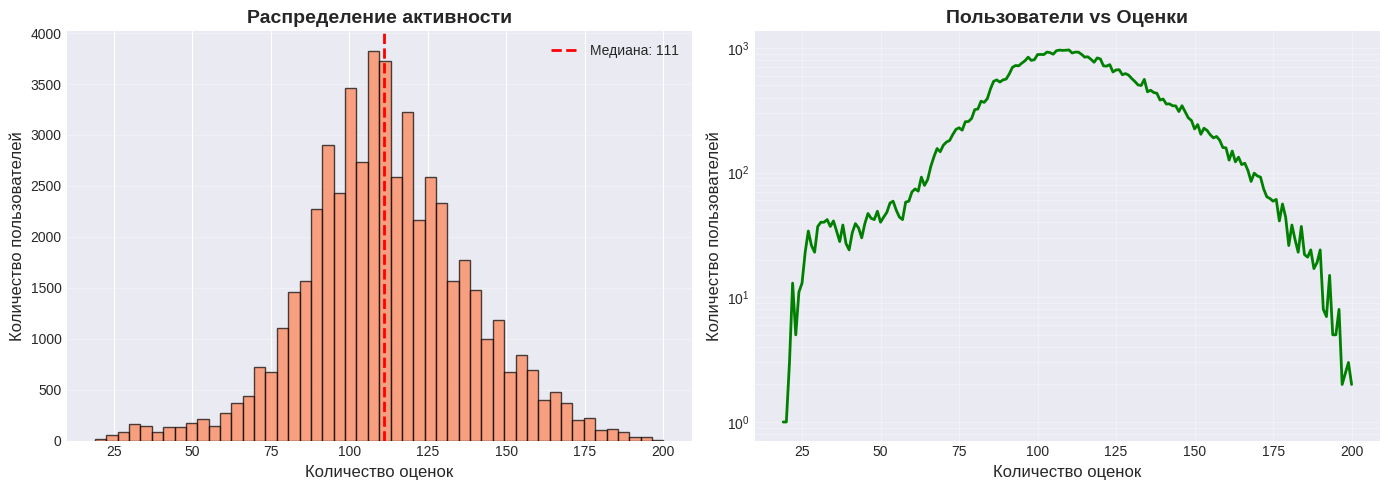


 Холодный старт: 0 (0.0%) пользователей <10 оценок
 Активные: 52525 (98.3%) пользователей >=50 оценок


In [9]:
user_activity = ratings.groupby('user_id').size().reset_index(name='num_ratings')

print("Статистика активности пользователей:")
display(user_activity['num_ratings'].describe())

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Гистограмма
axes[0].hist(user_activity['num_ratings'], bins=50, color='coral', edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Количество оценок', fontsize=12)
axes[0].set_ylabel('Количество пользователей', fontsize=12)
axes[0].set_title('Распределение активности', fontsize=14, fontweight='bold')
axes[0].axvline(user_activity['num_ratings'].median(), color='red',
               linestyle='--', linewidth=2, label=f"Медиана: {user_activity['num_ratings'].median():.0f}")
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# Зависимость
rating_dist = user_activity.groupby('num_ratings').size().sort_index()
axes[1].plot(rating_dist.index, rating_dist.values, linewidth=2, color='green')
axes[1].set_xlabel('Количество оценок', fontsize=12)
axes[1].set_ylabel('Количество пользователей', fontsize=12)
axes[1].set_title('Пользователи vs Оценки', fontsize=14, fontweight='bold')
axes[1].set_yscale('log')
axes[1].grid(True, alpha=0.3, which='both')

plt.tight_layout()
plt.show()

cold_start = (user_activity['num_ratings'] < 10).sum()
active = (user_activity['num_ratings'] >= 50).sum()

print(f"\n Холодный старт: {cold_start} ({cold_start/len(user_activity)*100:.1f}%) пользователей <10 оценок")
print(f" Активные: {active} ({active/len(user_activity)*100:.1f}%) пользователей >=50 оценок")


Среднее значение выставленных пользователями оценок (111.9) практически
совпадает с медианой распределения (111). Распределение симметричное
(колоколообразная форма), значит поведение пользователей является
предсказуемым и однородным.

Пользователи очень активны (98.3% имеют более 50 оценок), минимальное
количество оценок - 19. Однако в нашем датасете нет ни "новичков"
(отсутствует холодный старт), ни "суперпользователей" с высокой
активностью (>200 оценок).

В реальных системах такой ситуации скорее всего быть не может, и метрики
будут завышены относительно реальных условий. Для корректной оценки будем использовть временное разбиение (первые 80% оценок в train, последние
20% в test), что позволяет симулировать реалистичный сценарий: предсказываем следующую книгу опираясь на исторические данные поведения пользователя.

Пользователи с малым количеством оценок (<10) могут вначале получать популярные рекомендации, а в дальнейшем переходить на персонализированные модели

### Популярность книг

Статистика популярности книг:


,num_ratings
count,10000.000000
mean,597.647900
std,1267.289788
min,8.000000
25%,155.000000
50%,248.000000
75%,503.000000
max,22806.000000


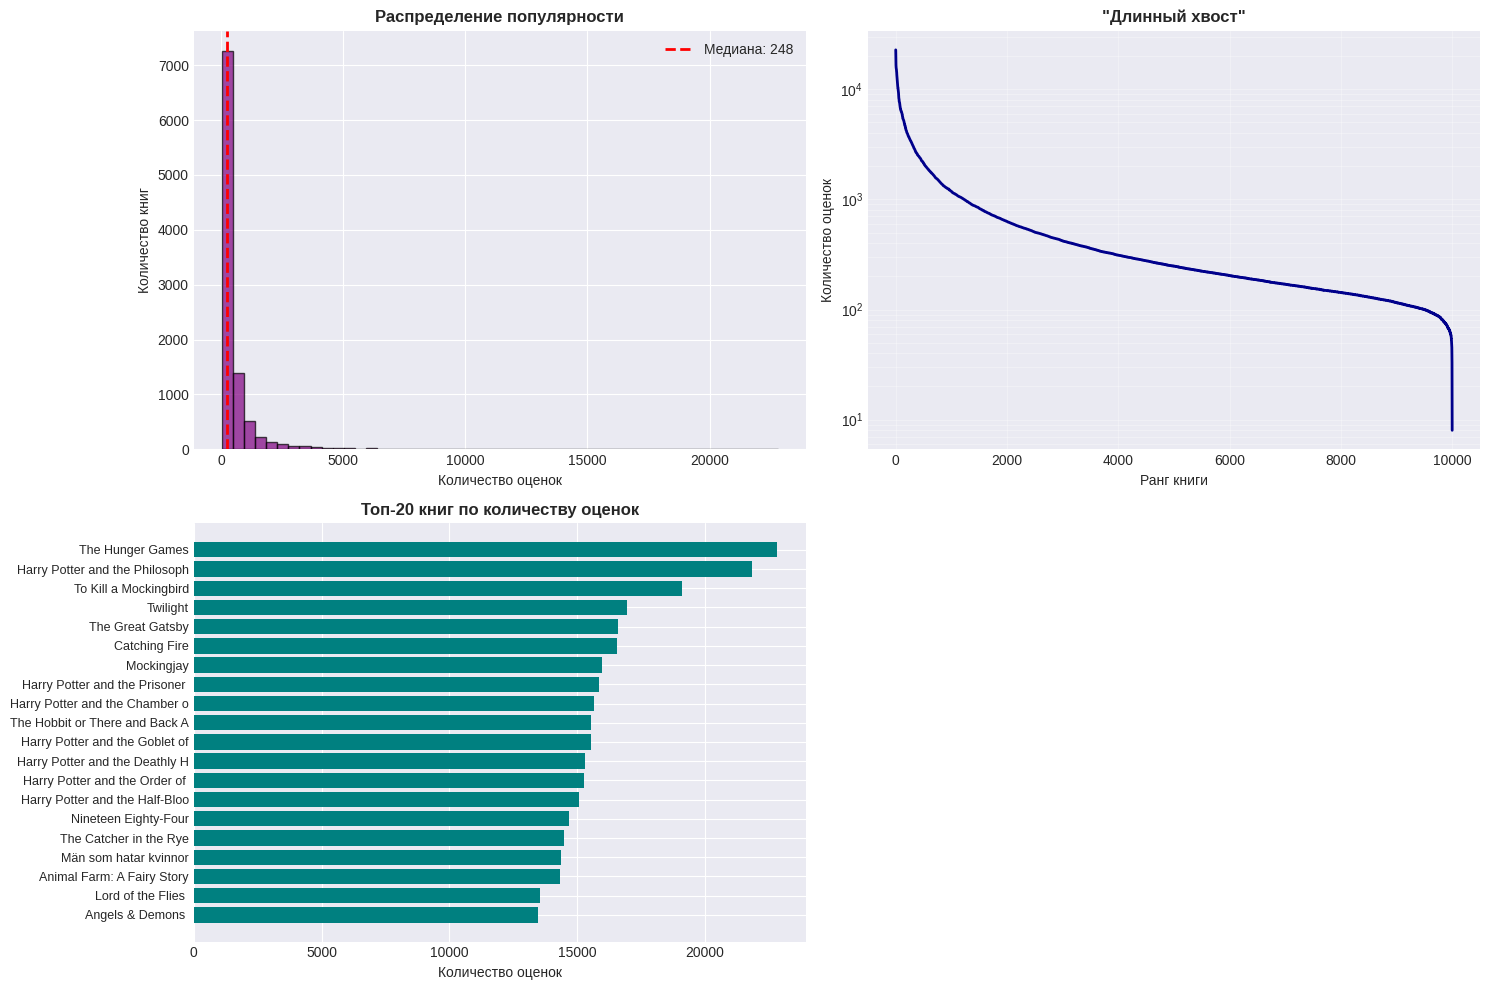


 Длинный хвост: 9 (0.1%) книг < 50 оценок
 Популярные: 2526 (25.3%) книг ≥ 500 оценок


In [10]:
book_pop = ratings.groupby('book_id').agg({'rating': ['count', 'mean']}).reset_index()
book_pop.columns = ['book_id', 'num_ratings', 'avg_rating']

print("Статистика популярности книг:")
display(book_pop['num_ratings'].describe())

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# --- График 1: Распределение ---
axes[0, 0].hist(book_pop['num_ratings'], bins=50, color='purple', edgecolor='black', alpha=0.7)
axes[0, 0].set_xlabel('Количество оценок')
axes[0, 0].set_ylabel('Количество книг')
axes[0, 0].set_title('Распределение популярности', fontweight='bold')
axes[0, 0].axvline(book_pop['num_ratings'].median(), color='red',
                   linestyle='--', linewidth=2, label=f"Медиана: {book_pop['num_ratings'].median():.0f}")
axes[0, 0].legend()

# Длинный хвост
sorted_pop = book_pop.sort_values('num_ratings', ascending=False).reset_index(drop=True)
axes[0, 1].plot(sorted_pop.index, sorted_pop['num_ratings'], linewidth=2, color='darkblue')
axes[0, 1].set_xlabel('Ранг книги')
axes[0, 1].set_ylabel('Количество оценок')
axes[0, 1].set_title('"Длинный хвост"', fontweight='bold')
axes[0, 1].set_yscale('log')
axes[0, 1].grid(True, alpha=0.3, which='both')

# Топ-20 книг
top_20 = book_pop.nlargest(20, 'num_ratings').merge(books[['book_id', 'original_title']], on='book_id', how='left')
top_20['short'] = top_20['original_title'].str[:30]

axes[1, 0].barh(range(20), top_20['num_ratings'], color='teal')
axes[1, 0].set_yticks(range(20))
axes[1, 0].set_yticklabels(top_20['short'], fontsize=9)
axes[1, 0].set_xlabel('Количество оценок')
axes[1, 0].set_title('Топ-20 книг по количеству оценок', fontweight='bold')
axes[1, 0].invert_yaxis()

axes[1, 1].axis('off')

plt.tight_layout()
plt.show()

long_tail = (book_pop['num_ratings'] < 50).sum()
popular = (book_pop['num_ratings'] >= 500).sum()

print(f"\n Длинный хвост: {long_tail} ({long_tail / len(book_pop) * 100:.1f}%) книг < 50 оценок")
print(f" Популярные: {popular} ({popular / len(book_pop) * 100:.1f}%) книг ≥ 500 оценок")



Медианное количество оценок на книгу составляет 248, при этом среднее
значение оценок на книгу в 2,4 раза больше — 598. Несколько суперпопулярных
книг завышают среднее значение. Например, топ-1 книга имеет 22,806 оценок
— в 92 раза больше медианы!

Мы видим, что большинство книг малопопулярны, и только незначительное
количество книг обращают на себя внимание пользователей. Мы имеем дело
с распределением с правосторонним смещением (right-skewed distribution),
которое противоположно нормальному распределению. В целом это типичная
ситуация для оценки популярности товаров в рекомендательных системах.

Это создает несколько проблем:

1. Несбалансированность данных: Для популярных книг много данных —
   их легко рекомендовать. Для малопопулярных книг данных мало — их
   сложно рекомендовать корректно. Нишевые интересы будут игнорироваться.

2. Смещение популярности (Popularity Bias): Модель обучается
   преимущественно на популярных книгах и может игнорировать релевантные,
   но непопулярные книги, что снижает разнообразие рекомендаций.

3. Разреженность матрицы: Матрица user-item будет сильно разреженной,
   так как для большинства книг очень мало оценок. Это затрудняет работу
   collaborative filtering методов."

### Теги

In [11]:
print("TAGS")
display( tags.head())
print("\n")
display( tags.tail())
print("\n")
tags.info()

TAGS


,tag_id,tag_name
0,0,-
1,1,--1-
2,2,--10-
3,3,--12-
4,4,--122-


,tag_id,tag_name
34247,34247,Ｃhildrens
34248,34248,Ｆａｖｏｒｉｔｅｓ
34249,34249,Ｍａｎｇａ
34250,34250,ＳＥＲＩＥＳ
34251,34251,ｆａｖｏｕｒｉｔｅｓ




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34252 entries, 0 to 34251
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   tag_id    34252 non-null  int64 
 1   tag_name  34252 non-null  object
dtypes: int64(1), object(1)
memory usage: 535.3+ KB


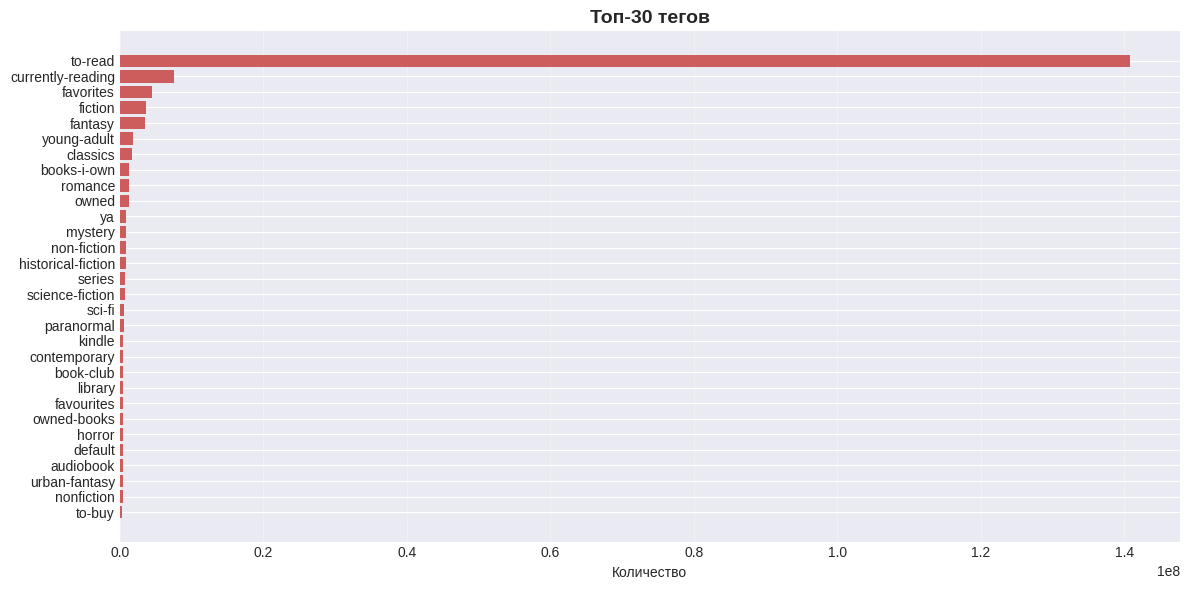


🏷️  Всего тегов: 34252
📊 Среднее тегов на книгу: 100.0
🎭 Топ-5: to-read, currently-reading, favorites, fiction, fantasy


In [12]:
# Анализ тегов
book_tags_named = book_tags.merge(tags, on='tag_id')
top_tags = (
    book_tags_named
    .groupby('tag_name')['count']
    .sum()
    .sort_values(ascending=False)
    .head(30)
)

plt.figure(figsize=(12, 6))
plt.barh(range(30), top_tags.values, color='indianred')
plt.yticks(range(30), top_tags.index, fontsize=10)
plt.xlabel('Количество')
plt.title('Топ-30 тегов', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

tags_per_book = book_tags.groupby('goodreads_book_id').size()

print(f"\n🏷️  Всего тегов: {len(tags)}")
print(f"📊 Среднее тегов на книгу: {tags_per_book.mean():.1f}")
print(f"🎭 Топ-5: {', '.join(top_tags.head(5).index)}")

Видно, что среди тегов присутствует те, что не имеют отношение к контенту.Например "to-read" - пользователь планирует прочитать / читает, "audiobook", "to-buy". Если выделить только контентные теги, то модель TF-IDF сфокусируется на реальных жанрах, улучшиться метрики Precision@K.

## Подготовка данных

In [13]:
# Функция разбиения на train/test
def temporal_split_by_user(ratings_df, train_ratio=0.8):
    """
    Первые train_ratio% оценок пользователя в train
    Последние (1-train_ratio)% в test
    """
    train_list = []
    test_list = []

    cold_start_users = 0
    total_users = 0

    for user_id, user_data in ratings_df.groupby('user_id'):
        total_users += 1
        user_sorted = user_data.sort_index()

        n_ratings = len(user_sorted)
        n_train = int(n_ratings * train_ratio)

        if n_train == 0:
            # Холодный старт: единственная оценка → в test
            test_list.append(user_sorted)
            cold_start_users += 1
        else:
            train_list.append(user_sorted.iloc[:n_train])
            test_list.append(user_sorted.iloc[n_train:])

    train_df = pd.concat(train_list, ignore_index=True) if train_list else pd.DataFrame()
    test_df = pd.concat(test_list, ignore_index=True) if test_list else pd.DataFrame()

    print(f" Train: {len(train_df):,} оценок ({len(train_df)/len(ratings_df)*100:.1f}%)")
    print(f" Test:  {len(test_df):,} оценок ({len(test_df)/len(ratings_df)*100:.1f}%)")
    print(f"\n Всего пользователей: {total_users:,}")
    print(f" Холодный старт (1 оценка): {cold_start_users} ({cold_start_users/total_users*100:.1f}%)")

    return train_df, test_df

# разделяем данные
train_ratings, test_ratings = temporal_split_by_user(ratings, train_ratio=0.8)

print(f"\n Пользователи в train: {train_ratings['user_id'].nunique()}")
print(f" Пользователи в test: {test_ratings['user_id'].nunique()}")

 Train: 4,759,759 оценок (79.6%)
 Test:  1,216,720 оценок (20.4%)

 Всего пользователей: 53,424
 Холодный старт (1 оценка): 0 (0.0%)

 Пользователи в train: 53424
 Пользователи в test: 53424


In [14]:
# Определение релевантных книг
RELEVANCE_THRESHOLD = 4

test_relevant_items = defaultdict(set)
for _, row in test_ratings[test_ratings['rating'] >= RELEVANCE_THRESHOLD].iterrows():
    test_relevant_items[row['user_id']].add(row['book_id'])

print(f" Порог релевантности: {RELEVANCE_THRESHOLD}")
print(f" Среднее релевантных книг: {np.mean([len(v) for v in test_relevant_items.values()]):.2f}")


 Порог релевантности: 4
 Среднее релевантных книг: 15.59


## Популярные книги (Baseline)

In [15]:
# построение модели популярности
def build_pop_model(ratings_df, min_ratings=50):
    book_stats = ratings_df.groupby('book_id').agg({
        'rating': ['mean', 'count']
    }).reset_index()
    book_stats.columns = ['book_id', 'avg_rating', 'num_ratings']

    book_stats = book_stats[book_stats['num_ratings'] >= min_ratings]   # фильтруем по минимальному количеству оценок
    # сортируем по рейтингу и количеству
    popular_books = book_stats.sort_values(
        ['avg_rating', 'num_ratings'],
        ascending=[False, False]
    )['book_id'].tolist()

    return popular_books

# рекомендации
def recommend_pop(popular_books, user_id=None, n=10, exclude_books=None):

    recommendations = popular_books.copy()

    if exclude_books:
        recommendations = [b for b in recommendations if b not in exclude_books]

    return recommendations[:n]

# строим
popular_books = build_pop_model(train_ratings, min_ratings=50)

sample_user = train_ratings['user_id'].iloc[100]
user_books = set(train_ratings[train_ratings['user_id'] == sample_user]['book_id'])
recs = recommend_pop(popular_books, sample_user, n=5, exclude_books=user_books)

print(f"\nТоп-5 для пользователя {sample_user}:")
display(books[books['book_id'].isin(recs)][['book_id', 'original_title', 'average_rating']])


Топ-5 для пользователя 2:


,book_id,original_title,average_rating
3627,3628,The Complete Calvin and Hobbes,4.82
4482,4483,It's a Magical World: A Calvin and Hobbes Coll...,4.75
7946,7947,ESV Study Bible,4.76
9565,9566,Attack of the Deranged Mutant Killer Monster S...,4.72
9805,9806,ONE PIECE 38,4.63


Пользователь получает глобальный топ-5 самых популярных книг (по среднему рейтингу и числу оценок), за исключением тех произведений, которые он уже читал или оценивал.

## Контентная фильтрация (TF-IDF)

In [16]:
# Подготовка контентных профилей книг
book_tags_agg = book_tags.merge(tags, on='tag_id')
book_tag_lists = book_tags_agg.groupby('goodreads_book_id')['tag_name'].apply(
    lambda x: ' '.join(x)
).reset_index()
book_tag_lists.columns = ['goodreads_book_id', 'tags']

books_content = books[['book_id', 'goodreads_book_id', 'original_title']].merge(
    book_tag_lists, on='goodreads_book_id', how='left'
)
books_content['tags'] = books_content['tags'].fillna('')
books_content['content_profile'] = (
    books_content['original_title'].fillna('') + ' ' + books_content['tags']
)

display(books_content[['book_id', 'original_title', 'content_profile']].head(2))

,book_id,original_title,content_profile
0,1,The Hunger Games,The Hunger Games favorites currently-reading y...
1,2,Harry Potter and the Philosopher's Stone,Harry Potter and the Philosopher's Stone to-re...


In [17]:
def build_content_model(books_content_df):
    vectorizer = TfidfVectorizer(
        max_features=5000,
        stop_words='english',
        ngram_range=(1, 2)
    )
    tfidf_matrix = vectorizer.fit_transform(books_content_df['content_profile'])

    if tfidf_matrix.dtype != np.float32:
        tfidf_matrix = tfidf_matrix.astype(np.float32, copy=False)

    # L2-нормировка строк (книг): cosine(a,b) == (a_norm · b_norm)
    row_norms = sparse.linalg.norm(tfidf_matrix, axis=1)
    row_norms[row_norms == 0] = 1.0
    tfidf_norm = sparse.diags(1.0 / row_norms, dtype=np.float32) @ tfidf_matrix  # CSR

    book_id_to_idx = dict(zip(
        books_content_df['book_id'].values,
        range(len(books_content_df))
    ))
    idx_to_book_id = {v: k for k, v in book_id_to_idx.items()}

    return tfidf_norm.tocsr(), book_id_to_idx, idx_to_book_id

    # Построение модели
tfidf_matrix, book_id_to_idx, idx_to_book_id = build_content_model(books_content)

print(f" TF-IDF матрица: {tfidf_matrix.shape}")

 TF-IDF матрица: (10000, 5000)


In [18]:
# 2) похожие книги без полной сортировки
def get_similar_books(book_id, tfidf_matrix, book_id_to_idx, idx_to_book_id, n=5):
    if book_id not in book_id_to_idx:
        return []
    idx = book_id_to_idx[book_id]

    # scores: (1 x terms) @ (terms x items) -> (1 x items)
    scores = (tfidf_matrix[idx:idx+1] @ tfidf_matrix.T).toarray().ravel()
    scores[idx] = -np.inf  # исключаем саму книгу

    n_pick = min(n, scores.size - 1)
    if n_pick <= 0:
        return []

    top_idx = np.argpartition(scores, -n_pick)[-n_pick:]
    top_idx = top_idx[np.argsort(scores[top_idx])[::-1]]
    return [idx_to_book_id[i] for i in top_idx[:n]]

# 3) быстрые рекомендации: профиль пользователя + один матмул
_user_profile_cache = {}  # опционально: кэш профилей

def _build_user_profile(user_id, user_ratings_df, tfidf_matrix, book_id_to_idx, alpha=1.0):
    u = user_ratings_df[(user_ratings_df['user_id'] == user_id) & (user_ratings_df['rating'] >= 4)]
    if u.empty:
        return None

    idxs, weights = [], []
    for b, r in zip(u['book_id'].values, u['rating'].values):
        i = book_id_to_idx.get(b)
        if i is not None:
            idxs.append(i)
            weights.append((float(r)) ** alpha)

    if not idxs:
        return None

    W = sparse.csr_matrix(np.asarray(weights, dtype=np.float32).reshape(1, -1))
    item_block = tfidf_matrix[idxs, :]                # CSR (m x terms)
    profile = W @ item_block                          # CSR (1 x terms)

    # L2-нормируем профиль — важно для косинуса
    nrm = sparse.linalg.norm(profile)
    if nrm > 0:
        profile = (profile * (1.0 / nrm)).tocsr()
    return profile

def recommend_content_based(user_id, user_ratings_df, tfidf_matrix,
                            book_id_to_idx, idx_to_book_id, n=5):
    # кэш (по желанию можно убрать 4 строки ниже)
    prof = _user_profile_cache.get(user_id)
    if prof is None:
        prof = _build_user_profile(user_id, user_ratings_df, tfidf_matrix, book_id_to_idx)
        _user_profile_cache[user_id] = prof

    if prof is None or prof.nnz == 0:
        return []

    # скорим все книги разом
    scores = (prof @ tfidf_matrix.T).toarray().ravel()

    # обнулим/исключим уже виденные книги
    seen = set(user_ratings_df.loc[user_ratings_df['user_id'] == user_id, 'book_id'])
    for b in seen:
        i = book_id_to_idx.get(b)
        if i is not None:
            scores[i] = -np.inf
    scores[np.isnan(scores)] = -np.inf

    n_pick = min(n, scores.size)
    if n_pick <= 0:
        return []

    top_idx = np.argpartition(scores, -n_pick)[-n_pick:]
    top_idx = top_idx[np.argsort(scores[top_idx])[::-1]]

    recs = []
    for i in top_idx:
        bid = idx_to_book_id.get(i)
        if bid is not None and bid not in seen:
            recs.append(bid)
        if len(recs) >= n:
            break
    return recs

In [19]:
# похожие книги
sample_book = 1
similar = get_similar_books(sample_book, tfidf_matrix, book_id_to_idx, idx_to_book_id, n=5)

print(f"Книги похожие на '{books[books['book_id']==sample_book]['original_title'].values[0]}':")
display(books[books['book_id'].isin(similar)][['book_id', 'original_title']])

# рекомендации
sample_user = train_ratings['user_id'].iloc[100]
content_recs = recommend_content_based(sample_user, train_ratings, tfidf_matrix,
                                       book_id_to_idx, idx_to_book_id, n=5)

print(f"\nРекомендации для пользователя {sample_user}:")
if content_recs:
    display(books[books['book_id'].isin(content_recs)][['book_id', 'original_title']])
else:
    print("Нет рекомендаций")

Книги похожие на 'The Hunger Games':


,book_id,original_title
11,12,Divergent
16,17,Catching Fire
19,20,Mockingjay
165,166,Matched
506,507,The Hunger Games Box Set



Рекомендации для пользователя 2:


,book_id,original_title
536,537,The Power of Habit
989,990,Rework
1620,1621,Drive: The Surprising Truth About What Motivat...
2328,2329,Getting to Yes: Negotiating agreement without ...
5785,5786,The Dip: A Little Book That Teaches You When t...


## коллаборативная фильтрация (Collaborative Filtering)

In [20]:
# Построение матрицы с явными оценками (rating)
user_item_matrix = csr_matrix(
    (train_ratings['rating'].values,
     (train_ratings['user_id'].values - 1, train_ratings['book_id'].values - 1)),
    shape=(train_ratings['user_id'].max(), train_ratings['book_id'].max())
)
print(f"   Размерность: {user_item_matrix.shape} ")
print(f"   Заполненность: {user_item_matrix.nnz:,} ячеек")
print(f"   Разреженность: {100 * (1 - user_item_matrix.nnz / np.prod(user_item_matrix.shape)):.2f}%")

   Размерность: (53424, 10000) 
   Заполненность: 4,759,759 ячеек
   Разреженность: 99.11%


In [21]:
item_matrix = user_item_matrix.T.tocsr()
item_matrix_norm = normalize(item_matrix, norm='l2', axis=1)
item_similarity = item_matrix_norm @ item_matrix_norm.T

print(f"   Размерность: {item_similarity.shape} (books × books)")
print(f"   Ненулевых элементов: {item_similarity.nnz:,}")

   Размерность: (10000, 10000) (books × books)
   Ненулевых элементов: 43,061,730


In [22]:
def predict_itemcf_rating(user_id, book_id, user_item_matrix, item_similarity, k=20):
    user_idx = user_id - 1
    item_idx = book_id - 1

    # оценки пользователя
    user_ratings = user_item_matrix[user_idx].toarray().flatten()
    rated_items = user_ratings.nonzero()[0]

    if len(rated_items) == 0:
    # ставим нейтральную оценку «ни нравится, ни не нравится»,
    # если у пользователя нет ни одной оценки — нечего использовать для предсказания
      return 3.0

    # схожести целевой книги с другими
    item_sims = item_similarity[item_idx].toarray().flatten()

    # топ-K похожих среди оцененных пользователем
    sims_with_ratings = [(item_sims[i], user_ratings[i])
                         for i in rated_items if i != item_idx]

    if not sims_with_ratings:
    # ставим нейтральную оценку «ни нравится, ни не нравится», если пользователь что-то оценивал,
    # но ни одна из оценённых книг не похожа на целевую (сходство = 0)
      return 3.0

    sims_with_ratings.sort(reverse=True, key=lambda x: x[0])
    top_k = sims_with_ratings[:k]

    # Взвешенное усреднение
    weighted_sum = sum(sim * rating for sim, rating in top_k)
    sum_of_sims = sum(abs(sim) for sim, _ in top_k)

    return weighted_sum / sum_of_sims if sum_of_sims > 0 else 3.0

In [23]:
                  # Рекомендация топ-N книг для пользователя
def recommend_books(user_id, user_item_matrix, item_similarity, books_df, n=10, k=20):

    user_idx = user_id - 1

    user_ratings = user_item_matrix[user_idx].toarray().flatten()   # оцененные книги
    rated_books = set(user_ratings.nonzero()[0] + 1)

    all_books = set(range(1, user_item_matrix.shape[1] + 1))
    candidates = all_books - rated_books

    predictions = []
    for book_id in candidates:
        pred = predict_itemcf_rating(user_id, book_id, user_item_matrix, item_similarity, k)
        predictions.append((book_id, pred))

    predictions.sort(key=lambda x: x[1], reverse=True)  # Топ-N
    return predictions[:n]

In [24]:
demo_user_id = 321   # Выбираем пользователя

user_books = train_ratings[train_ratings['user_id'] == demo_user_id]
print(f"\n Пользователь ID {demo_user_id}")
print(f"   Оценил книг: {len(user_books)}")

print(f"\n Его любимые книги (rating ≥ 4):")
fav = user_books[user_books['rating'] >= 4].merge(
    books[['book_id', 'original_title']], on='book_id'
)
for _, row in fav.head(3).iterrows():
    print(f"   • {row['original_title']}")

# для конкретной книги
target_book_id = 1
target_book = books[books['book_id'] == target_book_id].iloc[0]

predicted = predict_itemcf_rating(demo_user_id, target_book_id,
                          user_item_matrix, item_similarity, k=20)
print(f"   Ожидаемый рейтинг для книги '{target_book['original_title']}':   {predicted}")

# Топ-5 рекомендаций
recs = recommend_books(demo_user_id, user_item_matrix, item_similarity,
                      books, n=5, k=20)

recs_ids = [book_id for book_id, _ in recs]
print(f"\n Рекомендованные книги: {recs_ids}")
for book_id, pred_rating in recs:
    title = books[books['book_id'] == book_id]['original_title'].values[0]
    print(f"   • ID {book_id}: {title[:50]}... (predicted: {pred_rating:.2f})")



 Пользователь ID 321
   Оценил книг: 127

 Его любимые книги (rating ≥ 4):
   • Dreams from My Father
   • Three Cups of Tea 
   • Tuesdays with Morrie
   Ожидаемый рейтинг для книги 'The Hunger Games':   4.012670392617977

 Рекомендованные книги: [9853, 6373, 8771, 786, 3363]
   • ID 9853: Bad Kitty... (predicted: 4.76)
   • ID 6373: David Goes To School... (predicted: 4.75)
   • ID 8771: There's a Nightmare in My Closet (Pied Piper Book)... (predicted: 4.75)
   • ID 786: Falling Up... (predicted: 4.75)
   • ID 3363: Dr. Seuss's ABC: An Amazing Alphabet Book! (Bright... (predicted: 4.74)


Мы видим, что разреженность матрицы user–item составляет 99.11%. Пользователи оценивают лишь небольшую часть книг — это нормально и отражает реальную ситуацию.

Матрица item–item содержит более 43 млн ненулевых значений. Она довольно плотная, так как многие книги имеют общих читателей. Работа с такой матрицей требует больших вычислительных ресурсов, особенно при добавлении новых пользователей и книг.

Оптимальным решением будет «разрежение» матрицы item–item — оставляем только K ближайших соседей для каждой книги (например, 50 или 100). Это значительно снижает размер и ускоряет расчёты.

Главная проблема этой модели — масштабирование. При увеличении числа книг и пользователей растёт вычислительная сложность и время на рекомендации, что может быть критично для онлайн-сервисов, где важно быстро реагировать на новые оценки.

Возможные решения:

Матричная факторизация (ALS, SVD) — базовый вариант для больших данных.

Approximate Nearest Neighbors (Annoy, FAISS) — быстрый поиск похожих книг.

Кэширование и предвычисление популярных рекомендаций.

Распределённые вычисления (Spark) для ускорения обработки.

## Матричные разложения (Matrix Factorization) - ALS (Alternating Least Squares)

In [25]:
print(train_ratings.columns)

Index(['user_id', 'book_id', 'rating'], dtype='object')


In [26]:
ALPHA = 40
# преобразуем train
train_confidence = train_ratings.copy()
train_confidence['confidence'] = 1 + ALPHA * train_confidence['rating']

print(f"   • Alpha: {ALPHA}")
print(f"   • Формула: confidence = 1 + {ALPHA} * rating")
print(train_confidence[['user_id', 'book_id', 'rating', 'confidence']].head(5))


   • Alpha: 40
   • Формула: confidence = 1 + 40 * rating
   user_id  book_id  rating  confidence
0        1      258       5         201
1        1      268       3         121
2        1     5556       3         121
3        1     3638       3         121
4        1     1796       5         201


Библиотека implicit работает с неявными данными (клики, просмотры).
Для явных оценок (rating 1-5) используем формулу confidence: confidence = 1 + alpha * rating

  • rating=5 → confidence=201 (очень уверены, что нравится)

  • rating=4 → confidence=161 (уверены)

  • rating=3 → confidence=121 (средне)

  • rating=2 → confidence=81  (не нравится)

  • rating=1 → confidence=41  (точно не нравится)
  

Чем выше rating, тем больше "уверенность" модели.

In [27]:
print(train_confidence.columns)

Index(['user_id', 'book_id', 'rating', 'confidence'], dtype='object')


In [28]:
# приводим индексы к 0-base
unique_users = sorted(train_ratings['user_id'].unique())
unique_books = sorted(train_ratings['book_id'].unique())

user_id_to_idx = {uid: idx for idx, uid in enumerate(unique_users)}
book_id_to_idx = {bid: idx for idx, bid in enumerate(unique_books)}
idx_to_book_id = {idx: bid for bid, idx in book_id_to_idx.items()}

n_users = len(unique_users)
n_books = len(unique_books)

train_conf_idx = train_confidence.copy()
train_conf_idx['user_idx'] = train_conf_idx['user_id'].map(user_id_to_idx)
train_conf_idx['book_idx'] = train_conf_idx['book_id'].map(book_id_to_idx)

if train_conf_idx[['user_idx', 'book_idx']].isna().any().any():
    train_conf_idx = train_conf_idx.dropna(subset=['user_idx', 'book_idx'])

Приводим реальные user_id и book_id к внутренним индексам (0..N-1) - для построения матрицы user х book и универсальной работы модели с любыми датасетами (в т.ч. с холодным стартом).

In [29]:
# Строим матрицу
train_interactions = coo_matrix(
    (
        train_conf_idx['confidence'].values,
        (
            train_conf_idx['user_idx'].astype(int).values,  # ← ROW = users!
            train_conf_idx['book_idx'].astype(int).values   # ← COL = books!
        )
    ),
    shape=(n_users, n_books)  # ← (users, books) = (53424, 10000)
).tocsr()

print(f"Матрица: {' Ок!' if train_interactions.shape == (n_users, n_books) else 'False!'}")

# Обучаем ALS
print("\nОбучение ALS...")

als_model = implicit.als.AlternatingLeastSquares(
    factors=100,
    iterations=20,
    regularization=0.01,
    random_state=42
)

als_model.fit(train_interactions)

print(f"   • Латентных факторов: {als_model.factors}")
print(f"   • User factors shape: {als_model.user_factors.shape}")
print(f"   • Item factors shape: {als_model.item_factors.shape}")

# проверим размерность
expected_user_shape = (n_users, 100)
expected_item_shape = (n_books, 100)

actual_user_shape = als_model.user_factors.shape
actual_item_shape = als_model.item_factors.shape

print(f" User:   {' Ок!' if expected_user_shape == actual_user_shape else 'False!'}")
print(f" Item:   {' Ок!' if expected_item_shape == actual_item_shape else 'False!'}")

Матрица:  Ок!

Обучение ALS...


  0%|          | 0/20 [00:00<?, ?it/s]

   • Латентных факторов: 100
   • User factors shape: (53424, 100)
   • Item factors shape: (10000, 100)
 User:    Ок!
 Item:    Ок!


In [30]:
# Функции получения рекомендаций
def recommend_als(als_model, user_id, interactions_matrix,
                  user_id_to_idx, idx_to_book_id, n=10):
    if user_id not in user_id_to_idx:
        return []

    user_idx = user_id_to_idx[user_id]
    book_indices, scores = als_model.recommend(
         user_idx,
         interactions_matrix[user_idx],
         N=n*3,
         filter_already_liked_items=True
    )
    recommended_books = [idx_to_book_id[idx] for idx in book_indices            # конвертируем обратно
                            if idx in idx_to_book_id]

    return recommended_books[:n]


def get_recommendations(user_id, N=5):    # Топ-N рекомендаций
    recs = recommend_als(
        als_model, user_id, train_interactions,
        user_id_to_idx, idx_to_book_id, n=N
    )
# дополним популярными, популярными если нужно
    if len(recs) < N:
        user_books = set(train_ratings[train_ratings['user_id'] == user_id]['book_id'])
        user_books.update(recs)

        for book_id in popular_books:
            if book_id not in user_books:
                recs.append(book_id)
            if len(recs) >= N:
                break
    return recs[:N]

In [31]:
print("РЕКОМЕНДАЦИИ")

test_users = [123, 100, 1000, 599990]

for user_id in test_users:
    print(f"\n{'─'*80}")
    print(f" Пользователь ID: {user_id}")

    if user_id not in user_id_to_idx:
        print(f"    Не в train")
        continue

    user_idx = user_id_to_idx[user_id]
    max_idx = als_model.user_factors.shape[0] - 1

    print(f"   Индекс: {user_idx} (max: {max_idx})")

    user_books = train_ratings[train_ratings['user_id'] == user_id]
    print(f"   В train: ")
    print(f"   Оценил книг: {len(user_books)}")
    print(f"   Средняя оценка: {user_books['rating'].mean():.2f}")

    recs = get_recommendations(user_id, N=5)
    print(f"\n    Рекомендаций: {len(recs)}")

    if recs:
        print(f"    Книги:")
        for i, book_id in enumerate(recs, 1):
            title = books[books['book_id'] == book_id]['original_title'].values
            if len(title) > 0:
                print(f"      {i}. [{book_id}] {title[0][:50]}")
    else:
        print(f"    Нет рекомендаций")

РЕКОМЕНДАЦИИ

────────────────────────────────────────────────────────────────────────────────
 Пользователь ID: 123
   Индекс: 122 (max: 53423)
   В train: 
   Оценил книг: 84
   Средняя оценка: 3.96

    Рекомендаций: 5
    Книги:
      1. [362] A Grief Observed
      2. [329] The Last Lecture
      3. [489] The Prophet
      4. [493] Mere Christianity
      5. [1655] The Friday Night Knitting Club

────────────────────────────────────────────────────────────────────────────────
 Пользователь ID: 100
   Индекс: 99 (max: 53423)
   В train: 
   Оценил книг: 64
   Средняя оценка: 3.50

    Рекомендаций: 5
    Книги:
      1. [272] Como agua para chocolate
      2. [1624] La Nausée
      3. [2097] Demian: Die Geschichte einer Jugend
      4. [3928] When Nietzsche Wept: A Novel of Obsession
      5. [2926] Kniha smíchu a zapomnění

────────────────────────────────────────────────────────────────────────────────
 Пользователь ID: 1000
   Индекс: 999 (max: 53423)
   В train: 
   Оценил книг

Если пользователь не встречался в train, то мы его пропускаем, т.е.
есть для новых (холодных) пользователей ничего не выводится.

На данном этапе: чистый SVD (матрица user × book). В будущем
добавить гибридизацию:
  - fallback на популярные книги для холодных пользователей;
  - контентные признаки (жанры, авторы);
  - блендинг с Item-based CF или ALS.

In [32]:
# Предсказание оценок для ALS (implicit)

def to_numpy_2d(X):
    # implicit.gpu._cuda.Matrix обычно имеет .to_numpy()
    if hasattr(X, "to_numpy"):
        X = X.to_numpy()
    elif hasattr(X, "get"):            # cupy.ndarray
        X = X.get()
    elif hasattr(X, "copy_to_host"):   # rmm/cudf
        X = X.copy_to_host()
    elif hasattr(X, "toarray"):        # sparse
        X = X.toarray()
    A = np.asarray(X)
    if A.ndim == 1:
        A = A.reshape(-1, 1)
    assert A.ndim == 2, f"Expected 2D factors, got {A.ndim}D (type={type(X)})"
    return A.astype(np.float32, copy=False)

UF = to_numpy_2d(als_model.user_factors)   # (n_users, k)
IF = to_numpy_2d(als_model.item_factors)   # (n_items, k)ems, k)

def _map_idx(df):
    u = df['user_id'].map(user_id_to_idx).values
    i = df['book_id'].map(book_id_to_idx).values
    return u, i

def _dot_scores(UF, IF, u_idx, i_idx):
    mask = (~np.isnan(u_idx)) & (~np.isnan(i_idx))
    out = np.full(len(u_idx), np.nan, dtype=np.float32)
    if mask.any():
        uu = u_idx[mask].astype(np.int64)
        ii = i_idx[mask].astype(np.int64)
        out[mask] = np.einsum('ij,ij->i', UF[uu], IF[ii], optimize=True)
    return out

# калибровка score→rating на TRAIN
train_u, train_i = _map_idx(train_ratings)
train_scores = _dot_scores(UF, IF, train_u, train_i)
mask_tr = ~np.isnan(train_scores)

cal_model = LinearRegression().fit(
    train_scores[mask_tr].reshape(-1, 1),
    train_ratings.loc[mask_tr, 'rating'].values
)
a, b = float(cal_model.intercept_), float(cal_model.coef_[0])
# print(f"Параметры калибровки: a={a:.4f}, b={b:.4f}")

user_mean = train_ratings.groupby('user_id')['rating'].mean().to_dict()
global_mean = float(train_ratings['rating'].mean())

def fallback(user_id):
    return float(np.clip(user_mean.get(user_id, global_mean), 1.0, 5.0))

def predict_als_rating(user_id, book_id):
    u = user_id_to_idx.get(user_id)
    v = book_id_to_idx.get(book_id)
    if (u is None) or (v is None):
        return fallback(user_id)
    score = float(UF[u].dot(IF[v]))
    pred = float(cal_model.predict([[score]])[0])
    return float(np.clip(pred, 1.0, 5.0))

# оценим на TEST
test_sample = test_ratings.sample(min(10000, len(test_ratings)), random_state=42)
test_u, test_i = _map_idx(test_sample)
test_scores = _dot_scores(UF, IF, test_u, test_i)

pred = np.full(len(test_sample), np.nan, dtype=np.float32)
mask_te = ~np.isnan(test_scores)
if mask_te.any():
    pred[mask_te] = cal_model.predict(test_scores[mask_te].reshape(-1, 1)).astype(np.float32)
if (~mask_te).any():
    miss_idx = np.where(~mask_te)[0]
    pred[miss_idx] = np.array([fallback(uid) for uid in test_sample['user_id'].iloc[miss_idx]], dtype=np.float32)
pred = np.clip(pred, 1.0, 5.0)

rmse = float(np.sqrt(mean_squared_error(test_sample['rating'].values, pred)))
mae  = float(mean_absolute_error(test_sample['rating'].values, pred))

print("\n ALS (implicit) + калибровка — КАЧЕСТВО НА TEST (все пользователи)")
print(f"RMSE = {rmse:.4f}")
print(f"MAE  = {mae:.4f}")
print(f"Средний рейтинг (факт): {test_sample['rating'].mean():.2f}")
print(f"Средний рейтинг (предсказан): {pred.mean():.2f}")


 ALS (implicit) + калибровка — КАЧЕСТВО НА TEST (все пользователи)
RMSE = 1.4653
MAE  = 1.1926
Средний рейтинг (факт): 3.90
Средний рейтинг (предсказан): 3.09


Модель ALS (implicit) обучалась на матрице взаимодействий «пользователь–книга» и предсказывает "интерес", а не реальный рейтинг.
Для перевода в шкалу 1–5 использована линейная калибровка: rating≈a+b⋅score

Результаты на тестовой выборке (по всем пользователям):

RMSE = 1.47

MAE = 1.19

Средний фактический рейтинг = 3.90

Средний предсказанный = 3.09

Мі видим, что модель улавливает направление предпочтений, но занижает оценки (смещение вниз).

Метрики RMSE/MAE не отражают реальную силу модели. Модель хорошо подходит для Top-N рекомендаций (что порекомендует, а не сколько поставит).
Метрики RMSE/MAE здесь ограниченно применимы — для честной оценки следует использовать Precision@K, Recall@K или NDCG@K.

ALS (implicit) предсказывает предпочтения корректно, но не предназначена для точного предсказания оценок.


## Оценка и сравнение моделей

In [33]:
# Параметры
REL_THRESHOLD = 4
TOP_REC = 5          # сколько рекомендаций отдаёт модель
K = 5                # по какому K считаем метрики
PROGRESS_EVERY = 100 # размер шага для отображения прогресса выполнения

# релевантность из TEST
test_relevant_items = (
    test_ratings.loc[test_ratings["rating"] >= REL_THRESHOLD]
    .groupby("user_id")["book_id"].apply(set).to_dict()
)

# только пользователи с релевантами и присутствующие в TRAIN
train_users = set(train_ratings["user_id"].unique())
eligible_users = [u for u, rel in test_relevant_items.items() if rel and u in train_users]
rng = np.random.default_rng(42)
TEST_USERS = rng.choice(eligible_users, size=min(1000, len(eligible_users)), replace=False)

# что пользователь видел в TRAIN (исключаем из рекомендаций)
def _seen_in_train(uid):
    return set(train_ratings.loc[train_ratings["user_id"] == uid, "book_id"])

# фильтр: убраем train-книги и обрезаем до K
def _postfilter_exclude_seen(recs, exclude_books=None, k=None):
    seen = set(exclude_books) if exclude_books is not None else set()
    out = []
    for b in recs or []:
        if b in seen:
            continue
        out.append(b)
        if k is not None and len(out) >= k:
            break
    return out

# приводим рекомендации к списку book_id длиной n
def _to_id_list(recs, n=TOP_REC):
    if recs is None:
        return []
    if len(recs) > 0 and isinstance(recs[0], (tuple, list)):  # [(id, score), ...]
        return [r[0] for r in recs[:n]]
    return list(recs)[:n]

# метрики
def precision_at_k(recommended, relevant, k=K):
    if not recommended: return 0.0
    rec_at_k = set(recommended[:k]); return len(rec_at_k & set(relevant)) / k

def recall_at_k(recommended, relevant, k=K):
    if not relevant or not recommended: return 0.0
    rec_at_k = set(recommended[:k]); return len(rec_at_k & set(relevant)) / len(relevant)

def ndcg_at_k(recommended, relevant, k=K):
    if not recommended: return 0.0
    rel = set(relevant)
    dcg  = sum(1.0 / log2(i+2) for i,b in enumerate(recommended[:k]) if b in rel)
    idcg = sum(1.0 / log2(i+2) for i in range(min(k, len(rel))))
    return dcg / idcg if idcg > 0 else 0.0

def get_recommendations_model(model_name, user_id, n=TOP_REC):
    seen = _seen_in_train(user_id)

    if model_name == "Popularity":
        try:
            recs = recommend_pop(popular_books, user_id, n=n, exclude_books=seen)
        except TypeError:
            recs = recommend_pop(popular_books, n=n)
        return _postfilter_exclude_seen(_to_id_list(recs, n=n), exclude_books=seen, k=n)

    elif model_name == "Content-Based":
        recs = recommend_content_based(
            user_id, train_ratings, tfidf_matrix,
            book_id_to_idx, idx_to_book_id, n=n
        )
        return _postfilter_exclude_seen(_to_id_list(recs, n=n), exclude_books=seen, k=n)

    elif model_name == "Item-Based CF":
        try:
            recs = recommend_books(user_id, user_item_matrix, item_similarity, books, n=n)
        except TypeError:
            recs = recommend_books(user_id, user_item_matrix, item_similarity, books, n=n, k=20)
        return _postfilter_exclude_seen(_to_id_list(recs, n=n), exclude_books=seen, k=n)

    elif model_name == "ALS":
        recs = recommend_als(
            als_model, user_id, train_interactions,
            user_id_to_idx, idx_to_book_id, n=n
        )
        return _postfilter_exclude_seen(_to_id_list(recs, n=n), exclude_books=seen, k=n)

    return []

# Оценка одной модели
def evaluate_model(model_name, users, progress_every=PROGRESS_EVERY):
    print(f"\n  Оценка модели: {model_name}  | пользователей: {len(users)}")
    precisions, recalls, ndcgs = [], [], []
    users_cnt = 0

    for idx, uid in enumerate(users, start=1):
        relevant = test_relevant_items.get(uid, set())
        if not relevant:
            continue

        recs = get_recommendations_model(model_name, uid, n=TOP_REC)  # ровно TOP_REC
        if not recs:
            continue

        precisions.append(precision_at_k(recs, relevant, K))
        recalls.append(recall_at_k(recs, relevant, K))
        ndcgs.append(ndcg_at_k(recs, relevant, K))
        users_cnt += 1

        if progress_every and (idx % progress_every == 0):
            print(f"   [{model_name}] обработано {idx}/{len(users)}")

    print(f" {model_name}: пользователей учтено = {users_cnt}")
    return {
        "precision": float(np.mean(precisions)) if precisions else 0.0,
        "recall":    float(np.mean(recalls))    if recalls    else 0.0,
        "ndcg":      float(np.mean(ndcgs))      if ndcgs      else 0.0,
        "users":     users_cnt,
    }

# ---- Запуск и сводная таблица ----
MODEL_NAMES = ["Popularity", "Content-Based", "Item-Based CF", "ALS"]
all_results = {name: evaluate_model(name, TEST_USERS) for name in MODEL_NAMES}

summary_df = pd.DataFrame([
    {"Модель": m, "K": K,
     "Precision@K": r["precision"], "Recall@K": r["recall"], "nDCG@K": r["ndcg"], "Users": r["users"]}
    for m, r in all_results.items()
]).sort_values("Модель").reset_index(drop=True)

with pd.option_context("display.float_format", "{:,.4f}".format):
    display(summary_df)


  Оценка модели: Popularity  | пользователей: 1000
   [Popularity] обработано 100/1000
   [Popularity] обработано 200/1000
   [Popularity] обработано 300/1000
   [Popularity] обработано 400/1000
   [Popularity] обработано 500/1000
   [Popularity] обработано 600/1000
   [Popularity] обработано 700/1000
   [Popularity] обработано 800/1000
   [Popularity] обработано 900/1000
   [Popularity] обработано 1000/1000
 Popularity: пользователей учтено = 1000

  Оценка модели: Content-Based  | пользователей: 1000
   [Content-Based] обработано 100/1000
   [Content-Based] обработано 200/1000
   [Content-Based] обработано 300/1000
   [Content-Based] обработано 400/1000
   [Content-Based] обработано 500/1000
   [Content-Based] обработано 600/1000
   [Content-Based] обработано 700/1000
   [Content-Based] обработано 800/1000
   [Content-Based] обработано 900/1000
   [Content-Based] обработано 1000/1000
 Content-Based: пользователей учтено = 1000

  Оценка модели: Item-Based CF  | пользователей: 1000
 

,Модель,K,Precision@K,Recall@K,nDCG@K,Users
0,ALS,5,0.0376,0.0131,0.0365,1000
1,Content-Based,5,0.0418,0.0153,0.0443,1000
2,Item-Based CF,5,0.0162,0.0055,0.0162,1000
3,Popularity,5,0.0002,0.0000,0.0001,1000


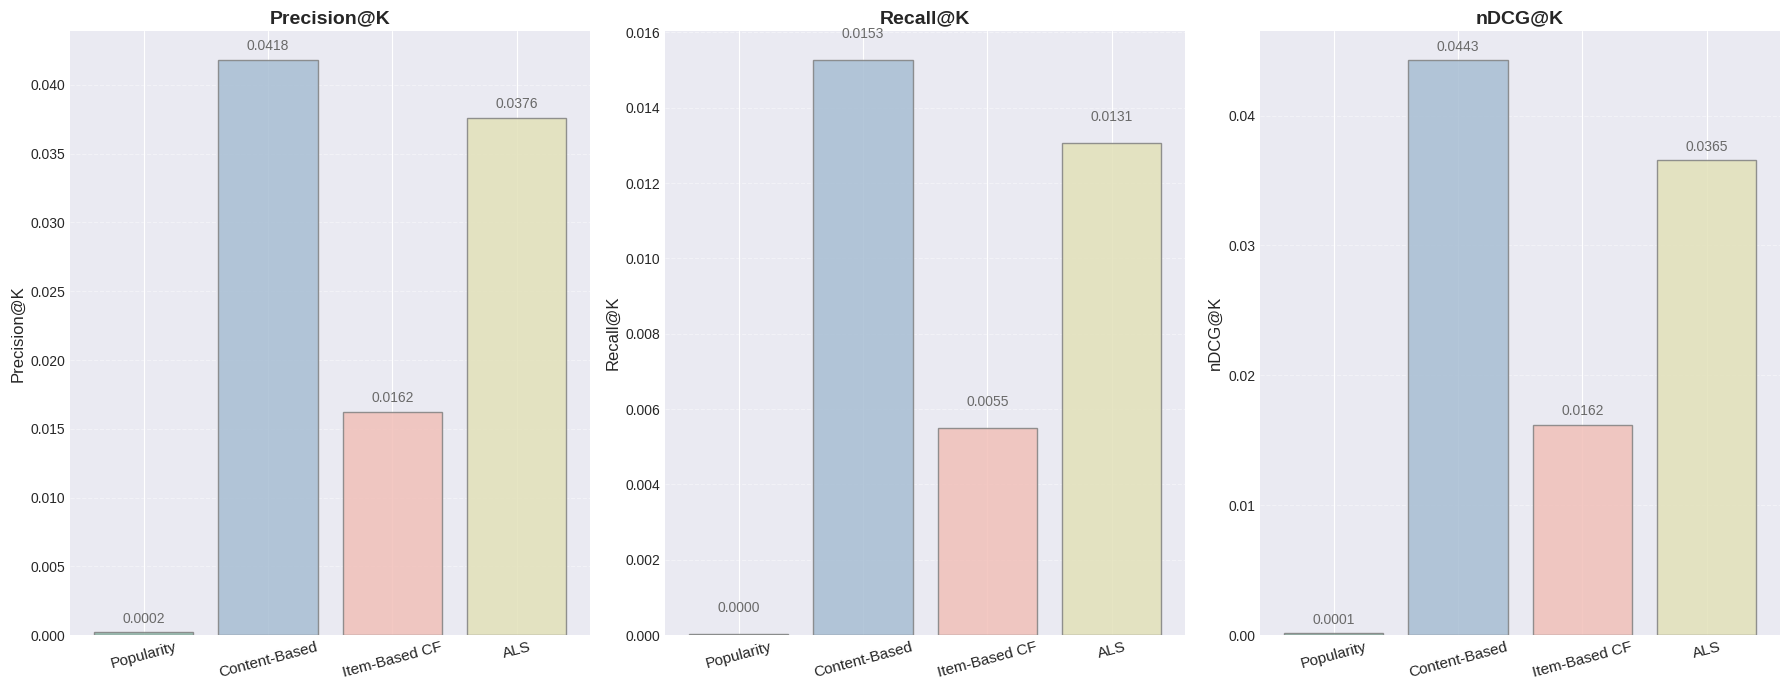

In [34]:
fig, axes = plt.subplots(1, 3, figsize=(18, 7))
metrics = ["precision", "recall", "ndcg"]
titles  = ["Precision@K", "Recall@K", "nDCG@K"]

model_order = list(all_results.keys())
x = np.arange(len(model_order))

# нежная цветовая палитра
colors = ["#8fb9aa", "#a7bed3", "#f1c0b9", "#e2e1b9", "#c9a7eb"]

for ax, metric, title in zip(axes, metrics, titles):
    ys = [all_results[m][metric] for m in model_order]
    ax.bar(x, ys, color=colors[:len(model_order)], edgecolor="gray", alpha=0.85)
    ax.set_xticks(x)
    ax.set_xticklabels(model_order, rotation=15, fontsize=11)
    ax.set_ylabel(title, fontsize=12)
    ax.set_title(title, fontsize=14, fontweight="bold")
    ax.grid(axis="y", linestyle="--", alpha=0.4)
    for i, y in enumerate(ys):
        ax.text(i, y + 0.0005, f"{y:.4f}", ha="center", va="bottom", fontsize=10, color="dimgray")

plt.tight_layout()
plt.show()

## Выводы и рекомендации

Content-Based (TF-IDF) показала наилучшее качество.

ALS (implicit) близка по качеству, масштабируется и подходит для больших датасетов.

Item-Based CF отработала слабее — ей нужно больше данных и плотных оценок.

Popularity — базовый уровень, без персонализации.


Чтобы улучнить качество модели, нужно использовать сильные стороны каждого подхода и комбинировать модели:
Новые пользователи: Popularity (глобальный топ).
Новые книги: Content-Based по тегам и описанию.
для известных: SVD/ALS или Item-CF

Для построения гибридной модели дополнительно можно использовать:

Текстовые эмбеддинги:
заменить TF-IDF на Word2Vec, FastText, или BERT-эмбеддинги описаний книг → лучше улавливают смысл, синонимы и жанровые связи.

Пользовательские фичи:
добавить возраст, язык, активность, любимые жанры → можно обучить LightFM, Neural CF, или двусторонний Transformer.

Нейросетевые подходы:
Neural Collaborative Filtering (NCF, NeuMF)

